# Thin Section Tile Extraction
This notebook processes carbonate thin section images to extract 114x114 tiles based on grid lines, classify them by labeled mask intensity (green channel), and save them as training data for deep learning.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd


In [2]:
# Define paths
input_root = os.path.join(os.getcwd(), "DAT", "LV1")
output_root = os.path.join(os.getcwd(), "FIG", "LV1")
label_root = os.path.join(os.getcwd(), "DAT", "LV2_cal")
os.makedirs(label_root, exist_ok=True)

# Toggle for saving tiles
save_tiles = True


In [3]:
for sample_name in sorted(os.listdir(input_root)):
    sample_path = os.path.join(input_root, sample_name)
    if not os.path.isdir(sample_path):
        continue

    try:
        grid_img = cv2.imread(os.path.join(sample_path, "grid.png"))
        rock_img = cv2.imread(os.path.join(sample_path, [f for f in os.listdir(sample_path) if "rock.png" in f][0]))
        num_img  = cv2.imread(os.path.join(sample_path, [f for f in os.listdir(sample_path) if "number.png" in f][0]))
    except:
        print(f"❗ Missing file in: {sample_name}")
        continue

    g_col = grid_img[:, 0, 1]
    g_row = grid_img[0, :, 1]
    grid_y = np.where(g_col < 10)[0]
    grid_x = np.where(g_row < 10)[0]

    tile_data = []
    label_data = []
    sample_out_dir = os.path.join(output_root, os.path.basename(sample_path))
    os.makedirs(sample_out_dir, exist_ok=True)

    total_tiles = 0
    saved_tiles = 0
    nan_labels = 0
    nan_examples = []

    for i in range(len(grid_y)-1):
        for j in range(len(grid_x)-1):
            y0, y1 = grid_y[i]+1, grid_y[i+1]-1
            x0, x1 = grid_x[j]+1, grid_x[j+1]-1
            h, w = y1 - y0 + 1, x1 - x0 + 1
            offset_y = (h - 104) // 2
            offset_x = (w - 104) // 2

            tile_rock = rock_img[y0+offset_y:y0+offset_y+104, x0+offset_x:x0+offset_x+104]
            # ➕ 샘플별 전체 타일 저장 (NaN 포함)
            sample_fig_dir = os.path.join("/Users/neobassist/thinsection_tiles/FIG/LV1", sample_name)
            os.makedirs(sample_fig_dir, exist_ok=True)
            tile_filename = os.path.join(sample_fig_dir, f"{total_tiles:05}.png")
            cv2.imwrite(tile_filename, tile_rock)
            total_tiles += 1
            tile_num  = num_img[y0+offset_y:y0+offset_y+104, x0+offset_x:x0+offset_x+104, 1]
            green_sum = np.sum(tile_num)

            # Label assignment
            if green_sum in [2352732, 2337959, 2362388, 2371041, 2362252, 2013310, 2204968, 2117141, 1880036, 1880004, 1888618]:
                label = 9
            elif green_sum in [2554862, 2556613, 2556307, 2296343, 2442203, 2262305, 2262289]:
                label = 1
            elif green_sum in [2424557, 2431136, 2430915, 2131341, 2305200, 2041655]:
                label = 3
            elif green_sum in [2348176, 2506259, 2358920, 2359090, 2013514, 2272203, 2205563, 2403885, 1881658, 1884962]:
                label = 6
            elif green_sum in [2345643, 2349162, 2349349, 1975825, 2209354, 1881567]:
                label = 8
            elif green_sum in [2424455, 2431799, 2099670, 2293844, 2020220, 2017180]:
                label = 4
            elif green_sum in [2502842, 2508758, 2251429, 2403307, 2201422]:
                label = 7
            elif green_sum in [2416839, 2428501, 2427328, 2179621, 2335613, 2094279]:
                label = 2
            elif green_sum in [2386783, 2395011, 2048092, 2240294, 1938527]:
                label = 5
            elif green_sum in [2409937, 2421310, 2171920, 2319548, 2076296]:
                label = 0
            else:
                label = 'nan'
                nan_labels += 1
                if len(nan_examples) < 5:
                    nan_examples.append(green_sum)
                continue

            total_tiles += 1
            filename = f"{total_tiles:05d}.png"
            tile_data.append([total_tiles, y0, x0, green_sum])
            label_data.append([filename, label])

            if save_tiles:
                saved_tiles += 1
                cv2.imwrite(os.path.join(sample_out_dir, filename), tile_rock)

    # Save .dat files
    df_coords = pd.DataFrame(tile_data, columns=["index", "y0", "x0", "green_sum"])
    df_labels = pd.DataFrame(label_data, columns=["filename", "label"])
    coord_path = os.path.join(label_root, os.path.basename(sample_path) + "_grid&rock.png.dat")
    label_path = os.path.join(label_root, os.path.basename(sample_path) + "_grid&rock.png_num.dat")
    df_coords.to_csv(coord_path, sep="\t", header=False, index=False)
    df_labels.to_csv(label_path, sep="\t", header=False, index=False)

    print(f"✅ [{sample_name}]")
    print(f"  Total tiles parsed  : {total_tiles + nan_labels}")
    print(f"  Saved tiles (valid) : {saved_tiles}")
    print(f"  Skipped (unknown)   : {nan_labels}")
    if nan_examples:
        print(f"  → Sample unknown green_sums: {nan_examples}")

✅ [(cali.) 20150212 HXND 2-3 (1)]
  Total tiles parsed  : 26596
  Saved tiles (valid) : 3834
  Skipped (unknown)   : 9464
  → Sample unknown green_sums: [2758080, 2758080, 2758080, 2758080, 2758080]
✅ [(cali.) 20150212 HXND 2-3 (2)]
  Total tiles parsed  : 26596
  Saved tiles (valid) : 2051
  Skipped (unknown)   : 11247
  → Sample unknown green_sums: [2758080, 2758080, 2758080, 2758080, 2758080]
✅ [(cali.) Unit 1 1-1(1,1)]
  Total tiles parsed  : 13746
  Saved tiles (valid) : 1064
  Skipped (unknown)   : 5809
  → Sample unknown green_sums: [2758080, 2758080, 2758080, 2758080, 2758080]
✅ [(cali.) Unit 1 1-2(1,1)]
  Total tiles parsed  : 28248
  Saved tiles (valid) : 4544
  Skipped (unknown)   : 9580
  → Sample unknown green_sums: [2758080, 2758080, 2758080, 2758080, 2758080]
✅ [(cali.) Unit 1 1-2(2,1)]
  Total tiles parsed  : 22610
  Saved tiles (valid) : 2031
  Skipped (unknown)   : 9274
  → Sample unknown green_sums: [2758080, 2758080, 2758080, 2758080, 2758080]
✅ [(cali.) Unit 1 1-2(

In [4]:
# Merge all extracted tiles into a single dataset directory organized by class

merged_dir = os.path.join(os.getcwd(), "DATASET")
os.makedirs(merged_dir, exist_ok=True)

for sample_name in sorted(os.listdir(output_root)):
    sample_path = os.path.join(output_root, sample_name)
    label_file = os.path.join(label_root, sample_name + "_grid&rock.png_num.dat")

    if not os.path.exists(label_file):
        print(f"⚠️ Label file not found for {sample_name}")
        continue

    labels_df = pd.read_csv(label_file, sep="\t", header=None, names=["filename", "label"])

    for idx, row in labels_df.iterrows():
        fname, label = row["filename"], str(row["label"])
        if label == "nan":
            continue  # skip unlabeled

        src_path = os.path.join(sample_path, fname)
        dst_folder = os.path.join(merged_dir, label)
        os.makedirs(dst_folder, exist_ok=True)
        dst_path = os.path.join(dst_folder, f"{sample_name}_{fname}")

        if os.path.exists(src_path):
            os.rename(src_path, dst_path)

print("✅ All tiles merged into DATASET/[class]/ folders.")


✅ All tiles merged into DATASET/[class]/ folders.


## 📊 Class Distribution Visualization and Dataset Splitting

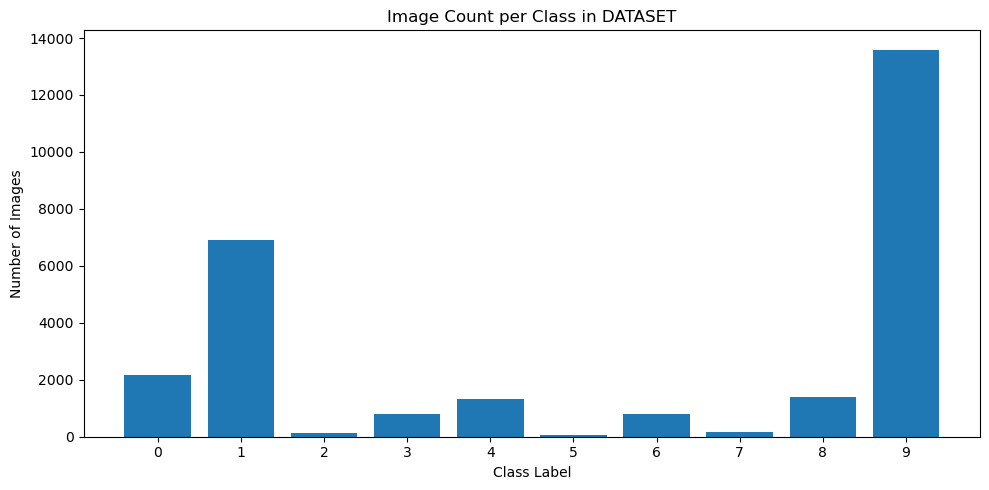

In [5]:
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

# Define dataset folders
merged_dir = os.path.join(os.getcwd(), "DATASET")
train_dir = os.path.join(os.getcwd(), "dataset_train")
val_dir = os.path.join(os.getcwd(), "dataset_val")
test_dir = os.path.join(os.getcwd(), "dataset_test")

# Create or clean target folders
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# Count images per class
class_counts = {}
for class_name in sorted(os.listdir(merged_dir)):
    class_path = os.path.join(merged_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.endswith(".png")]
        class_counts[class_name] = len(images)

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Image Count per Class in DATASET")
plt.tight_layout()
plt.savefig("image_class_distribution.png")
plt.show()


In [6]:
# Split into train, val, and test sets
for class_name in os.listdir(merged_dir):
    src_folder = os.path.join(merged_dir, class_name)
    images = [f for f in os.listdir(src_folder) if f.endswith(".png")]

    # Shuffle and split
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.1, random_state=42)  # 10% of train as val

    for subset, subset_imgs in zip(
        [train_dir, val_dir, test_dir],
        [train_imgs, val_imgs, test_imgs]
    ):
        class_dest = os.path.join(subset, class_name)
        os.makedirs(class_dest, exist_ok=True)
        for img in subset_imgs:
            shutil.copy(os.path.join(src_folder, img), os.path.join(class_dest, img))

print("✅ Split complete: dataset_train, dataset_val, dataset_test folders created.")


✅ Split complete: dataset_train, dataset_val, dataset_test folders created.


## 📦 Restructure Folders and Generate Label CSV

In [7]:
import os
import shutil
import pandas as pd

# 1. Rename merged dataset to DATASET_MERGE
if os.path.exists("DATASET"):
    os.rename("DATASET", "DATASET_MERGE")

# 2. Create new DATASET directory
os.makedirs("DATASET", exist_ok=True)

# 3. Move subset folders into DATASET/
for subset in ["dataset_train", "dataset_val", "dataset_test"]:
    if os.path.exists(subset):
        shutil.move(subset, os.path.join("DATASET", subset))

# 4. Generate dataset_labels.csv
dataset_root = "DATASET"
subsets = ["dataset_train", "dataset_val", "dataset_test"]
entries = []

for subset in subsets:
    subset_path = os.path.join(dataset_root, subset)
    for class_name in sorted(os.listdir(subset_path)):
        class_dir = os.path.join(subset_path, class_name)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.endswith(".png"):
                    rel_path = os.path.join(subset, class_name, fname)
                    entries.append([rel_path, class_name, subset])

df = pd.DataFrame(entries, columns=["filepath", "label", "subset"])
df.to_csv(os.path.join(dataset_root, "dataset_labels.csv"), index=False)

print("✅ Folder restructure and dataset_labels.csv generation complete.")


✅ Folder restructure and dataset_labels.csv generation complete.
